<a href="https://colab.research.google.com/github/WojciechMojsiejuk/GlaucomaDetection/blob/main/glaucoma_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/MachineLearning/

/content/gdrive/MyDrive/MachineLearning


In [ ]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/MachineLearning/'

In [ ]:
import kaggle

In [ ]:
!kaggle datasets download -d sshikamaru/glaucoma-detection

 97% 390M/402M [00:02<00:00, 140MB/s]
100% 402M/402M [00:03<00:00, 140MB/s]


In [ ]:
!ls

glaucoma-detection.zip	glaucoma_recognition.ipynb  kaggle.json


In [5]:
# unzip
import zipfile, os

path_to_zip = '/content/gdrive/MyDrive/MachineLearning/glaucoma-detection.zip'
dst_path = '/content/gdrive/MyDrive/MachineLearning/dataset'

if not os.path.exists(dst_path):
  os.makedirs(dst_path)
  with zipfile.ZipFile(path_to_zip, 'r') as file:
    file.extractall(dst_path)

In [6]:
data_path = os.path.join(dst_path,'Fundus_Train_Val_Data/Fundus_Scanes_Sorted')

In [7]:
train_path = os.path.join(data_path, 'Train')
validation_path = os.path.join(data_path, 'Validation')

In [8]:
random_seed = 10

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory


train_data = image_dataset_from_directory(train_path,
                                          image_size=(128,128),
                                          batch_size=20,
                                          crop_to_aspect_ratio=True,
                                          seed=random_seed,
                                          validation_split=0.1925,
                                          subset="training",
                                          label_mode='binary')

validation_data = image_dataset_from_directory(train_path,
                                              image_size=(128,128),
                                              batch_size=20,
                                              crop_to_aspect_ratio=True,
                                              seed=random_seed,
                                              validation_split=0.1925,
                                              subset="validation",
                                              label_mode='binary')

test_data = image_dataset_from_directory(validation_path,
                                        image_size=(128,128),
                                        batch_size=20,
                                        crop_to_aspect_ratio=True,
                                        label_mode='binary')


Found 520 files belonging to 2 classes.
Using 420 files for training.
Found 520 files belonging to 2 classes.
Using 100 files for validation.
Found 130 files belonging to 2 classes.


data batch shape: (20, 128, 128, 3)
labels batch shape: (20, 1)
image max value: 255.0


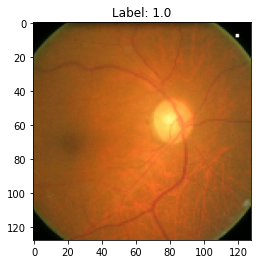

In [17]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.strings import as_string
import numpy as np
for x, y in train_data.take(1):
  print('data batch shape:', x.shape)
  print('labels batch shape:', y.shape)
  print('image max value:',np.max(x[0]))
  plt.title(f'Label: {y[0,0].numpy()}')
  plt.imshow(image.array_to_img(x[0]))
  break

We can see that the Image is typical 8 bit RGB image, that is the pixel values range from 0 to 255. For CNN model it is better to normalize the dataset to values from 0 to 1.

In [ ]:
from tensorflow.keras import layers

In [27]:
from tensorflow.keras.applications import Xception
conv_base = Xception(weights='imagenet', # randomly initialized parameters
                  include_top=False)

In [31]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(128, 128, 3))) # Rescaling
model.add(conv_base)
model.add(layers.Flatten()) # we must flatten the convolution layers to 1D array for Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 

In [32]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=2e-5,), loss='binary_crossentropy', metrics=['acc'])

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint
# save best epoch before it starts to overfit
modelckpt = ModelCheckpoint(
    monitor = 'val_acc',
    save_best_only=True,
    filepath=os.path.join(data_path, 'best_model.h5'))

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 1)                

In [37]:
history = model.fit(train_data,
                    steps_per_epoch=21,
                    epochs=30,
                    validation_data=validation_data,
                    validation_steps=5,
                    callbacks=[modelckpt])

Epoch 1/30
21/21 [==============================] - 14s 512ms/step - loss: 0.3480 - acc: 0.8714 - val_loss: 0.5457 - val_acc: 0.7500
Epoch 2/30
21/21 [==============================] - 13s 437ms/step - loss: 0.3439 - acc: 0.8833 - val_loss: 0.5482 - val_acc: 0.7400
Epoch 3/30
21/21 [==============================] - 13s 435ms/step - loss: 0.3237 - acc: 0.8738 - val_loss: 0.5438 - val_acc: 0.7800
Epoch 4/30
21/21 [==============================] - 13s 426ms/step - loss: 0.2932 - acc: 0.9000 - val_loss: 0.5397 - val_acc: 0.7800
Epoch 5/30
21/21 [==============================] - 14s 504ms/step - loss: 0.2880 - acc: 0.9024 - val_loss: 0.5460 - val_acc: 0.7800
Epoch 6/30
21/21 [==============================] - 13s 426ms/step - loss: 0.2717 - acc: 0.9119 - val_loss: 0.5320 - val_acc: 0.7600
Epoch 7/30
21/21 [==============================] - 13s 427ms/step - loss: 0.2589 - acc: 0.9095 - val_loss: 0.5590 - val_acc: 0.7500
Epoch 8/30
21/21 [==============================] - 14s 512ms/step - 

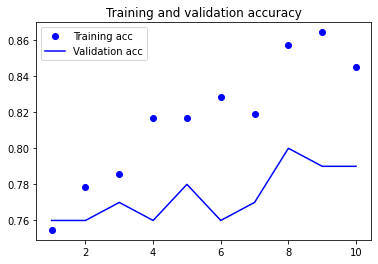

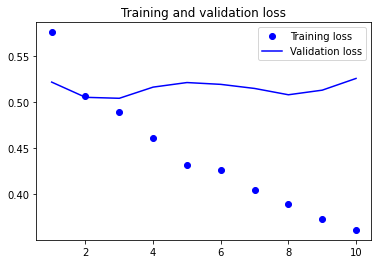

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras import models
model = models.load_model(os.path.join(data_path, 'best_model.h5'))

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=5e-6,), 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=21,
                    epochs=10,
                    validation_data=validation_data,
                    validation_steps=5)

Epoch 1/10
21/21 [==============================] - 15s 477ms/step - loss: 0.4121 - acc: 0.8357 - val_loss: 0.5152 - val_acc: 0.7900
Epoch 2/10
21/21 [==============================] - 14s 465ms/step - loss: 0.3225 - acc: 0.8810 - val_loss: 0.5182 - val_acc: 0.7800
Epoch 3/10
21/21 [==============================] - 14s 469ms/step - loss: 0.2594 - acc: 0.8952 - val_loss: 0.5139 - val_acc: 0.8000
Epoch 4/10
21/21 [==============================] - 14s 472ms/step - loss: 0.2162 - acc: 0.9095 - val_loss: 0.4824 - val_acc: 0.8000
Epoch 5/10
21/21 [==============================] - 14s 469ms/step - loss: 0.2035 - acc: 0.9238 - val_loss: 0.5116 - val_acc: 0.8000
Epoch 6/10
21/21 [==============================] - 14s 474ms/step - loss: 0.1613 - acc: 0.9476 - val_loss: 0.5144 - val_acc: 0.7900
Epoch 7/10
21/21 [==============================] - 14s 469ms/step - loss: 0.1461 - acc: 0.9643 - val_loss: 0.5323 - val_acc: 0.7900
Epoch 8/10
21/21 [==============================] - 14s 474ms/step - 

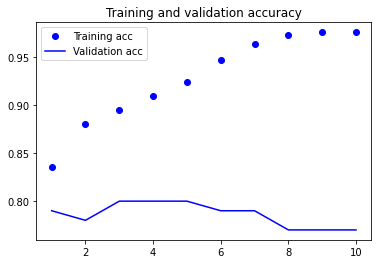

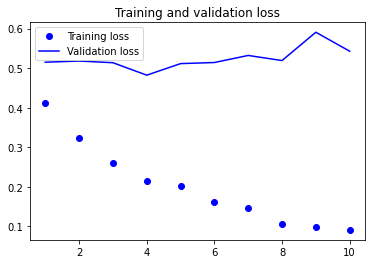

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()